## ConvNet

In [60]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

### Load data

In [61]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
trX = trX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
teX = teX.reshape(-1, 28, 28, 1)  # 28x28x1 input img

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Helper functions

In [62]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)

    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)

    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)

    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)

    pyx = tf.matmul(l4, w_o)
    return pyx

### Build graph

In [63]:
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 10])         # FC 625 inputs, 10 outputs (labels)

tf.histogram_summary("w", w)
tf.histogram_summary("w2", w2)
tf.histogram_summary("w3", w3)
tf.histogram_summary("w4", w4)
tf.histogram_summary("w_o", w_o)


p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
    train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
    tf.scalar_summary("cost", cost)

with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(Y,1), tf.argmax(py_x,1)) # Count correct predictions
    acc = tf.reduce_mean(tf.cast(correct_pred, "float")) # Cast boolean to float to average
    tf.scalar_summary("accuracy", acc)

### Launch graph
- Homework: add tensorboard summary

In [64]:
batch_size = 128
test_size = 256

# Launch the graph in a session
with tf.Session() as sess:
    writer = tf.train.SummaryWriter("./logs/CNN", sess.graph)
    merged = tf.merge_all_summaries()

    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(100):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})

        test_indices = np.arange(len(teX)) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]
                
        summary, accuracy = sess.run([merged, acc], feed_dict={X: teX[test_indices], 
                                                               Y: teY[test_indices],
                                                               p_keep_conv: 1., p_keep_hidden: 1.})
        
        writer.add_summary(summary, i)
        # print (iter, accuracy)
        print(i, accuracy)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_8' with dtype float
	 [[Node: Placeholder_8 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Placeholder_8', defined at:
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-dc560c717138>", line 1, in <module>
    X = tf.placeholder("float", [None, 28, 28, 1])
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1332, in placeholder
    name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1748, in _placeholder
    name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_8' with dtype float
	 [[Node: Placeholder_8 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### Visualization

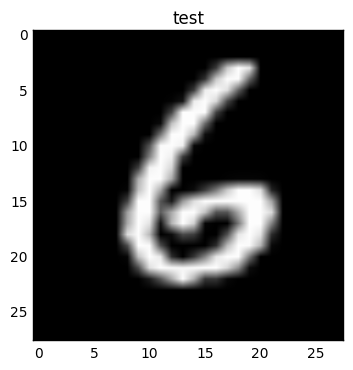

In [57]:
a = (trX[1000,:] * 255).reshape((28,28))
import matplotlib.pyplot as plt
a = np.array(a, dtype='uint8')
plt.title('test')
plt.imshow(a, cmap='gray')
plt.show()

In [66]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import tensorflow as tf

# Parameters
learning_rate = 0.001
training_iters = 200000
batch_size = 64
display_step = 20

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.8 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

# Create custom model
def conv2d(name, l_input, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(l_input, w, strides=[1, 1, 1, 1], padding='SAME'),b), name=name)

def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

def customnet(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    pool1 = max_pool('pool1', conv1, k=2)
    # Apply Normalization
    norm1 = norm('norm1', pool1, lsize=4)
    # Apply Dropout
    norm1 = tf.nn.dropout(norm1, _dropout)
    #conv1 image show
    tf.image_summary("conv1", conv1)
    # Convolution Layer
    conv2 = conv2d('conv2', norm1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    pool2 = max_pool('pool2', conv2, k=2)
    # Apply Normalization
    norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
    norm2 = tf.nn.dropout(norm2, _dropout)

    # Convolution Layer
    conv3 = conv2d('conv3', norm2, _weights['wc3'], _biases['bc3'])
    # Max Pooling (down-sampling)
    pool3 = max_pool('pool3', conv3, k=2)
    # Apply Normalization
    norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
    norm3 = tf.nn.dropout(norm3, _dropout)
    #conv4
    conv4 = conv2d('conv4', norm3, _weights['wc4'], _biases['bc4'])
    # Max Pooling (down-sampling)
    pool4 = max_pool('pool4', conv4, k=2)
    # Apply Normalization
    norm4 = norm('norm4', pool4, lsize=4)
    # Apply Dropout
    norm4 = tf.nn.dropout(norm4, _dropout)
    # Fully connected layer
    dense1 = tf.reshape(norm4, [-1, _weights['wd1'].get_shape().as_list()[0]]) # Reshape conv3 output to fit dense layer input
    dense1 = tf.nn.relu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1') # Relu activation

    dense2 = tf.nn.relu(tf.matmul(dense1, _weights['wd2']) + _biases['bd2'], name='fc2') # Relu activation

    # Output, class prediction
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    return out

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [67]:
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64])),
    'wc2': tf.Variable(tf.random_normal([3, 3, 64, 128])),
    'wc3': tf.Variable(tf.random_normal([3, 3, 128, 256])),
    'wc4': tf.Variable(tf.random_normal([2, 2, 256, 512])),
    'wd1': tf.Variable(tf.random_normal([2*2*512, 1024])), 
    'wd2': tf.Variable(tf.random_normal([1024, 1024])),
    'out': tf.Variable(tf.random_normal([1024, 10]))
}
biases = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([128])),
    'bc3': tf.Variable(tf.random_normal([256])),
    'bc4': tf.Variable(tf.random_normal([512])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = customnet(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [68]:
# Initializing the variables
init = tf.initialize_all_variables()
# 
tf.scalar_summary("loss", cost)
tf.scalar_summary("accuracy", accuracy)
# Merge all summaries to a single operator
merged_summary_op = tf.merge_all_summaries()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    summary_writer = tf.train.SummaryWriter('./logs/CNN', graph_def=sess.graph_def)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc)
            summary_str = sess.run(merged_summary_op, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            summary_writer.add_summary(summary_str, step)
        step += 1
    print "Optimization Finished!"
    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:256], y: mnist.test.labels[:256], keep_prob: 1.})


Iter 1280, Minibatch Loss= 153308.281250, Training Accuracy= 0.07812


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_16' with dtype float
	 [[Node: Placeholder_16 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Placeholder_16', defined at:
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "//anaconda/envs/tensorflow/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-915f1a591114>", line 1, in <module>
    X = tf.placeholder("float", [None, 28, 28, 1])
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1332, in placeholder
    name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1748, in _placeholder
    name=name)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "//anaconda/envs/tensorflow/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_16' with dtype float
	 [[Node: Placeholder_16 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
